# USNCCM15 Short Course
# SC15-005: Machine Learning Data-Driven Discretization Theories, Modeling and Applications

# Hands-on tutorial on Physics-Informed Neural Networks 
## (Part I: Continuous time formulation)
## Instructor: Paris Perdikaris, pgp@seas.upenn.edu
## Code repository: https://github.com/PredictiveIntelligenceLab/USNCCM15-Short-Course-Recent-Advances-in-Physics-Informed-Deep-Learning

# Physics-informed neural networks
The recent works of Raissi {\em et. al.} \cite{raissi2017physics1,raissi2017physics2, raissi2018hidden,raissi2018deep,raissi2019physics} have  demonstrated how classical conservation laws and numerical discretization schemes can be used as structured prior information that can enhance the robustness and efficiency of modern machine learning algorithms, introducing a new class of data-driven solvers, as well as a {\em physics-informed machine learning} approach to model discovery. To this end, the authors have considered constructing deep neural networks that return predictions which are constrained by parametrized partial differential equations (PDE) of the form

$$
{u}_t + \mathcal{N}_{{x}}{u} = 0,
$$

where $u(x,t)$ is represented by a deep neural network parametrized by a set of parameters $\theta$, i.e. $u({x},t) = f_{\theta}({x},t)$, ${x}$ is a vector of space coordinates, $t$ is the time coordinate, and $\mathcal{N}_{{x}}$ is a nonlinear differential operator. As neural networks are differentiable representations, this construction defines a so-called {\em physics informed neural network} that corresponds to the PDE residual, i.e. 

$$r_{\theta}({x},t):= \frac{\partial}{\partial t} f_{\theta}({x},t)  + \mathcal{N}_{{x}}f_{\theta}({x},t).$$

This new network has the same parameters as the network representing ${u}({x},t)$, albeit different activation functions due to the action of the differential operator \cite{raissi2017physics1, psichogios1992hybrid, lagaris1998artificial}. From an implementation perspective, this network can be readily obtained by leveraging recent progress in automatic differentiation \cite{baydin2015automatic, abadi2016tensorflow}.
The resulting training procedure allows us to recover the shared network parameters $\theta$ using a few scattered observations of ${u}({x},t)$, namely 

$$\{({x}_{i}, t_i), {u}_i\}, \ \ i = 1,\dots,N_u,$$

along with a larger number of collocation points, 

$$\{({x}_{i}, t_i), {r}_i\}, \ \ i = 1,\dots,N_r,$$

that aim to penalize the PDE residual at a finite set of $N_r$ collocation nodes. 
The data for the residual are typically zero (i.e. ${r}_i=0$), or they may correspond to external forcing terms evaluated at the corresponding location $({x}_{i}, t_i)$, $i=1,\dots,N_r$.

This simple, yet remarkably effective regularization procedure allows us to introduce the PDE residual as a soft penalty constraint penalty in the likelihood function of the model \cite{raissi2017physics1,raissi2017physics2}, and the resulting optimization problem can be effectively solved using standard stochastic gradient descent without necessitating any elaborate constrained optimization techniques, simply by minimizing the composite loss function

$$
\mathcal{L}(\theta) = \frac{1}{N_u}\sum\limits_{i=1}^{N_u}\|f_{\theta}({x}_{i}, t_i) - {u}_i\|^2  +   \frac{1}{N_r}\sum\limits_{i=1}^{N_r}\|r_{\theta}({x}_{i}, t_i) - {r}_i\|^2, 
$$

where the required gradients $\frac{\partial \mathcal{L}}{\partial \theta}$ can be readily obtained using automatic differentiation \cite{baydin2015automatic}. 
Finally, as the resulting predictions are encouraged to inherit any physical properties imposed by the PDE constraint (e.g., conservation, invariance, symmetries, etc.), this approach showcases how one can approximately encode physical and domain-specific constraints in modern machine learning algorithms and introduce a new form of regularization for learning from {\em small} data-sets.

In all cases pertaining to data-driven solution of partial differential equations, the total number of training data $N_u$ is relatively small (a few hundred up to a few thousand points), and we chose to optimize all loss functions using L-BFGS, a quasi-Newton, full-batch gradient-based optimization algorithm \cite{liu1989limited}. For larger data-sets, a more computationally efficient mini-batch setting can be readily employed using stochastic gradient descent and its modern variants \cite{goodfellow2016deep,kingma2014adam}. Despite the fact that there is no theoretical guarantee that this procedure converges to a global minimum, our empirical evidence indicates that, if the given partial differential equation is well-posed and its solution is unique, the method is capable of achieving good prediction accuracy given a sufficiently expressive neural network architecture and a sufficient number of collocation points $N_r$. 

# Tensorflow Implementation

To highlight different implementation aspects, consider a simple linear elliptic PDE in one dimension:

$$
u_{xx}(x) = f(x), \ \ x\in[-1.0,1.0],\\
u(-1)=u(1) = 0,
$$
with a forcing term given by
$$
f(x):= -\pi^2 \sin(\pi x)
$$

All elements defining our neural network implementation can be summarized in the following Tensorflow class.

In [11]:
# Import required packages
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import timeit
from tqdm import tqdm

# Fix random seeds for reproducibility
np.random.seed(1234)
tf.set_random_seed(1234)

In [12]:
'''
A basic PINN Tensorflow class for solving
u_xx = f(x)
'''
class Elliptic1D:
    # Initialize the class
    def __init__(self, X_u, Y_u, X_r, f_tf, layers):
        
        # Normalization constants
        self.mu_x, self.sigma_x = X_r.mean(0), X_r.std(0)
        
        # Normalize inputs
        X_u = (X_u - self.mu_x)/self.sigma_x
        X_r = (X_r - self.mu_x)/self.sigma_x
        
        self.N_u = X_u.shape[0]
        self.N_r = X_r.shape[0]
        
        # Store data                
        self.X_u = X_u
        self.Y_u = Y_u
        
        self.X_r = X_r
        self.Y_r = np.zeros((self.N_r,1))
        
        self.f = f_tf
        self.layers = layers
        
        # Initialize network weights and biases        
        self.weights, self.biases = self.initialize_NN(layers)
        
        # Define Tensorflow session
        self.sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
        
        # Define placeholders and computational graph
        self.Xu_tf = tf.placeholder(tf.float32, shape=(None, self.X_u.shape[1]))
        self.Yu_tf = tf.placeholder(tf.float32, shape=(None, self.Y_u.shape[1]))
        self.Xr_tf = tf.placeholder(tf.float32, shape=(None, self.X_r.shape[1]))
        
        # Evaluate prediction
        self.u_pred = self.net_u(self.Xu_tf)
        self.r_pred = self.net_r(self.Xr_tf)
        
        # Evaluate loss
        self.loss_u = tf.reduce_mean(tf.square(self.Yu_tf - self.u_pred))
        self.loss_r = tf.reduce_mean(tf.square(self.r_pred))
               
        self.loss = self.loss_u + self.loss_r
     
        # Define optimizer  with learning rate schedule
        self.global_step = tf.Variable(0, trainable=False)
        starter_learning_rate = 1e-3
        self.learning_rate = tf.train.exponential_decay(starter_learning_rate, self.global_step,
                                                   1000, 0.9, staircase=False)
        # Passing global_step to minimize() will increment it at each step.
        self.train_op = tf.train.AdamOptimizer(self.learning_rate).minimize(self.loss, global_step=self.global_step)
                
        # Define optimizer (use L-BFGS for better accuracy)       
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(np.float32).eps})
        
        # Logger
        self.loss_u_log = []
        self.loss_r_log = []
        self.saver = tf.train.Saver()
        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)

    
    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
       
           
    # Evaluates the forward pass
    def forward_pass(self, H):
        num_layers = len(self.layers)
        for l in range(0,num_layers-2):
            W = self.weights[l]
            b = self.biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = self.weights[-1]
        b = self.biases[-1]
        H = tf.add(tf.matmul(H, W), b)
        return H
    
    
    # Forward pass for u
    def net_u(self, x):
        u = self.forward_pass(x)
        return u
    
    
    # Forward pass for f
    def net_r(self, x):
        # lhs
        u = self.net_u(x)
        u_x = tf.gradients(u, x)[0]/self.sigma_x
        u_xx = tf.gradients(u_x, x)[0]/self.sigma_x
        
        # rhs
        f = self.f(x*self.sigma_x + self.mu_x)
        
        residual = u_xx - f
        return residual

    # Callback to print the loss at every optimization step
    def callback(self, loss_u, loss_r):
        print('Loss_u: %.3e, Loss_r: %.3e' % 
                      (loss_u, loss_r))

    # Trains the model by minimizing the MSE loss using Adam
    def train(self, nIter = 10000): 
        
        # Define a dictionary for associating placeholders with data
        tf_dict = {self.Xu_tf: self.X_u, self.Yu_tf: self.Y_u,
                   self.Xr_tf: self.X_r}

        start_time = timeit.default_timer()
        for it in tqdm(range(nIter)):                 
            # Run the Tensorflow session to minimize the loss
            self.sess.run(self.train_op, tf_dict)
            
            # Print
            if it % 50 == 0:
                elapsed = timeit.default_timer() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                loss_u_value = self.sess.run(self.loss_u, tf_dict)
                loss_r_value = self.sess.run(self.loss_r, tf_dict)
                self.loss_u_log.append(loss_u_value)
                self.loss_r_log.append(loss_r_value)
#                 print('It: %d, Loss: %.3e, Loss_u: %.3e, Loss_r: %.3e, Time: %.2f' % 
#                       (it, loss_value, loss_u_value, loss_r_value, elapsed))
                start_time = timeit.default_timer()
            
    # Trains the model by minimizing the MSE loss using L-BFGS
    def fine_tune(self):
        # Define a dictionary for associating placeholders with data
        tf_dict = {self.Xu_tf: self.X_u, self.Yu_tf: self.Y_u,
                   self.Xr_tf: self.X_r}

        # Call SciPy's L-BFGS otpimizer
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss_u, self.loss_r], 
                                loss_callback = self.callback)
        
                
    # Evaluates predictions at test points           
    def predict_u(self, X_star):
        X_star = (X_star - self.mu_x)/self.sigma_x
        tf_dict = {self.Xu_tf: X_star}       
        u_star = self.sess.run(self.u_pred, tf_dict) 
        return u_star
    
    # Evaluates predictions at test points           
    def predict_r(self, X_star):     
        X_star = (X_star - self.mu_x)/self.sigma_x
        tf_dict = {self.Xr_tf: X_star}       
        r_star = self.sess.run(self.r_pred, tf_dict) 
        return r_star

# Example simulation

Now we are ready to set up and execute our first PINN simulation. For this problem we know that the exact solution is given by

$$
u(x) = \sin(\pi x)
$$
and we can use this to validate the neural net predictions.

In [13]:
# Define forcing term
def f(x):
    return -np.pi**2 * np.sin(np.pi*x)

# Define forcing term (in Tensorflow semantics)
def f_tf(x):
    return -np.pi**2 * tf.sin(np.pi*x)
    
# Define exact solution (for validation purposes)    
def u(x):
    return np.sin(np.pi*x)

# Number of training data
N_u = 2                        # Boundary condition data on u(x)
N_r = 200                      # Number of collocation points for minimizing the PDE residual
lb  = np.array([-1.0])         # Left boundary of the domain
ub  = np.array([1.0])          # Right boundary of the domain

# Generate training data
x_u = np.linspace(lb, ub, N_u)     # Location of boundary points (dimension N_u x 1)
x_r = np.linspace(lb, ub, N_r)     # Location of collocation points (dimension N_r x 1)
y_u = u(x_u)                       # Solution at boundary points (dimension N_u x 1)

# Test data for validating the model predictions
n_star = 5000
x_star = np.linspace(lb, ub, n_star)
u_star = u(x_star)
f_star = f(x_star)

In [14]:
# Fully-connected neural net architecture (dimensions of each layer)
layers = [1,50,50,50,50,1]
#  Define PINN model
model = Elliptic1D(x_u, y_u, x_r, f_tf, layers)   

In [15]:
# Load stored model
# model.saver.restore(model.sess, "../SavedModels/elliptic1d.ckpt")

# Train model using full batch gradient descent
model.train(20000)

100%|██████████| 20000/20000 [00:48<00:00, 413.40it/s]


In [16]:
# Compute prediction using the trained model
u_pred = model.predict_u(x_star)
error_u = np.linalg.norm(u_star-u_pred, 2)/np.linalg.norm(u_star, 2)
print('Relative L2 error_u: %e' % (error_u))

Relative L2 error_u: 4.438422e-06


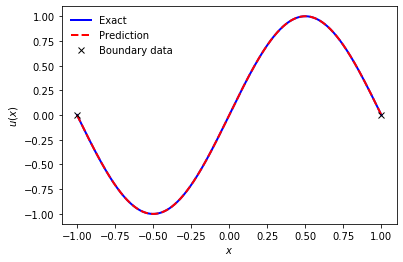

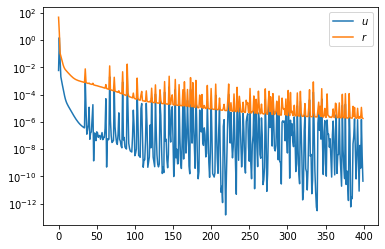

In [17]:
# Plotting
plt.figure(1)
plt.plot(x_star, u_star, 'b-', linewidth = 2, label = "Exact")
plt.plot(x_star, u_pred, 'r--', linewidth = 2, label = "Prediction")
plt.plot(x_u, y_u, 'kx', linewidth = 2, label = "Boundary data")
plt.legend(frameon=False, loc='upper left')
plt.xlabel('$x$')
plt.ylabel('$u(x)$')


fig = plt.figure(2)
ax = fig.add_subplot(1,1,1)
ax.plot(model.loss_u_log, label = '$u$')
ax.plot(model.loss_r_log, label = '$r$')
ax.set_yscale('log')
plt.legend()

In [18]:
# Save model
model.saver.save(model.sess, "../SavedModels/elliptic1d.ckpt")

'../SavedModels/elliptic1d.ckpt'